In [3]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.autograd import Variable

import torchvision
import torchvision.transforms as transforms

In [4]:
import wandb

run = wandb.init(
    # Set the project where this run will be logged
    project="my-awesome-project",
    # Track hyperparameters and run metadata
    config={
        "learning_rate": 0.01,
        "epochs": 10,
    },
)

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: jzon (jzon-agh-university-of-krakow). Use `wandb login --relogin` to force relogin


In [5]:
train_set = torchvision.datasets.FashionMNIST(
    "./data", download=True, transform=transforms.Compose([transforms.ToTensor()])
)
test_set = torchvision.datasets.FashionMNIST(
    "./data", download=True, train=False, transform=transforms.Compose([transforms.ToTensor()])
)

100.0%


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100.0%


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100.0%


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100.0%

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [6]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=100)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=100)

<h1>Supervised Learning - Classification

In [7]:
def output_label(label):
    output_mapping = {
        0: "T-shirt/Top",
        1: "Trouser",
        2: "Pullover",
        3: "Dress",
        4: "Coat",
        5: "Sandal",
        6: "Shirt",
        7: "Sneaker",
        8: "Bag",
        9: "Ankle Boot",
    }
    input = label.item() if type(label) == torch.Tensor else label
    return output_mapping[input]

In [8]:
a = next(iter(train_loader))
a[0].size()

torch.Size([100, 1, 28, 28])

In [9]:
len(train_set)

60000

9


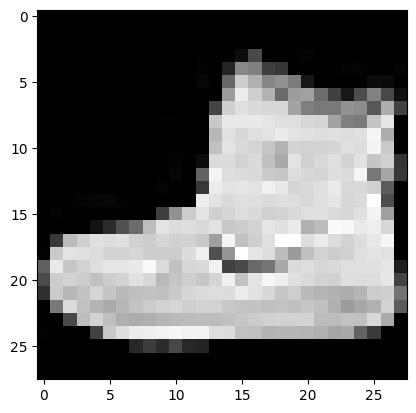

In [10]:
image, label = next(iter(train_set))
plt.imshow(image.squeeze(), cmap="gray")
print(label)

In [11]:
demo_loader = torch.utils.data.DataLoader(train_set, batch_size=10)

batch = next(iter(demo_loader))
images, labels = batch
print(type(images), type(labels))
print(images.shape, labels.shape)

<class 'torch.Tensor'> <class 'torch.Tensor'>
torch.Size([10, 1, 28, 28]) torch.Size([10])


labels:  Ankle Boot, T-shirt/Top, T-shirt/Top, Dress, T-shirt/Top, Pullover, Sneaker, Pullover, Sandal, Sandal, 

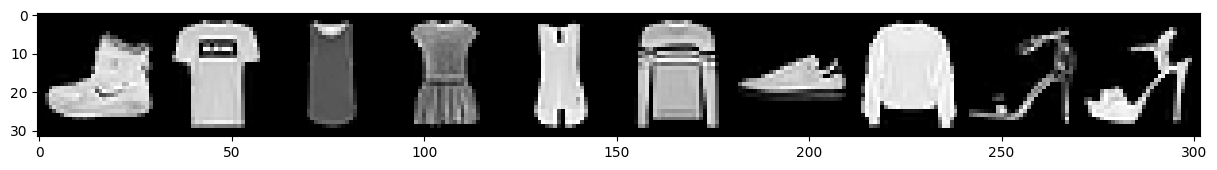

In [12]:
grid = torchvision.utils.make_grid(images, nrow=10)

plt.figure(figsize=(15, 20))
plt.imshow(np.transpose(grid, (1, 2, 0)))
print("labels: ", end=" ")
for i, label in enumerate(labels):
    print(output_label(label), end=", ")

In [13]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [14]:
class FashionCNN(nn.Module):

    def __init__(self):
        super(FashionCNN, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3), nn.BatchNorm2d(64), nn.ReLU(), nn.MaxPool2d(2)
        )

        self.fc1 = nn.Linear(in_features=64 * 6 * 6, out_features=600)
        self.drop = nn.Dropout2d(0.25)
        self.fc2 = nn.Linear(in_features=600, out_features=120)
        self.fc3 = nn.Linear(in_features=120, out_features=10)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.drop(out)
        out = self.fc2(out)
        out = self.fc3(out)

        return out

In [15]:
model = FashionCNN()
model.to(device)

error = nn.CrossEntropyLoss()

learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
print(model)

FashionCNN(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=2304, out_features=600, bias=True)
  (drop): Dropout2d(p=0.25, inplace=False)
  (fc2): Linear(in_features=600, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=10, bias=True)
)


In [17]:
num_epochs = 5
count = 0
# Lists for visualization of loss and accuracy
loss_list = []
iteration_list = []
accuracy_list = []

# Lists for knowing classwise accuracy
predictions_list = []
labels_list = []

for epoch in range(num_epochs):
    for images, labels in train_loader:
        # Transferring images and labels to GPU if available
        images, labels = images.to(device), labels.to(device)

        train = Variable(images.view(100, 1, 28, 28))
        labels = Variable(labels)

        # Forward pass
        outputs = model(train)
        loss = error(outputs, labels)

        # Initializing a gradient as 0 so there is no mixing of gradient among the batches
        optimizer.zero_grad()

        # Propagating the error backward
        loss.backward()

        # Optimizing the parameters
        optimizer.step()

        count += 1

        # Testing the model

        if not (count % 50):  # It's same as "if count % 50 == 0"
            total = 0
            correct = 0

            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                labels_list.append(labels)

                test = Variable(images.view(100, 1, 28, 28))

                outputs = model(test)

                predictions = torch.max(outputs, 1)[1].to(device)
                predictions_list.append(predictions)
                correct += (predictions == labels).sum()

                total += len(labels)

            accuracy = correct * 100 / total
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)
            # log metrics to wandb
            wandb.log({"acc": accuracy, "loss": loss.data})

        if not (count % 500):
            print("Iteration: {}, Loss: {}, Accuracy: {}%".format(count, loss.data, accuracy))
        
        
        
wandb.finish()

/Users/juliazon/.pyenv/versions/3.12.2/lib/python3.12/site-packages/torch/nn/functional.py:1347: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Iteration: 500, Loss: 0.5009927153587341, Accuracy: 87.56999969482422%
Iteration: 1000, Loss: 0.33989495038986206, Accuracy: 88.23999786376953%


KeyboardInterrupt: 

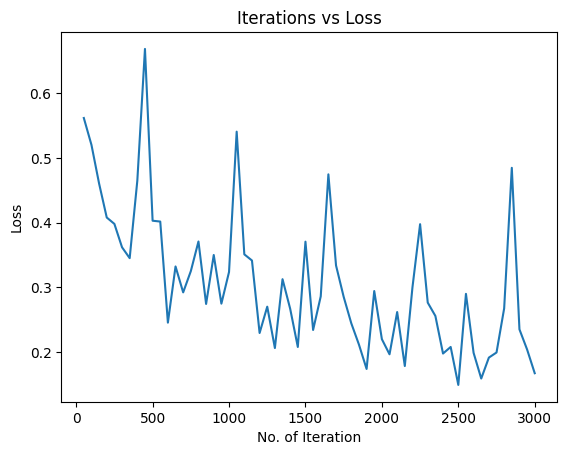

In [ ]:
# loss_list = np.stack([t.cpu().numpy() for t in loss_list])
# accuracy_list = np.stack([t.cpu().numpy() for t in accuracy_list])

plt.plot(iteration_list, loss_list)
plt.xlabel("No. of Iteration")
plt.ylabel("Loss")
plt.title("Iterations vs Loss")
plt.show()

In [ ]:
plt.plot(iteration_list, accuracy_list)
plt.xlabel("No. of Iteration")
plt.ylabel("Accuracy")
plt.title("Iterations vs Accuracy")
plt.show()

In [ ]:
class_correct = [0.0 for _ in range(10)]
total_correct = [0.0 for _ in range(10)]

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        test = Variable(images)
        outputs = model(test)
        predicted = torch.max(outputs, 1)[1]
        c = (predicted == labels).squeeze()

        for i in range(100):
            label = labels[i]
            class_correct[label] += c[i].item()
            total_correct[label] += 1

for i in range(10):
    print("Accuracy of {}: {:.2f}%".format(output_label(i), class_correct[i] * 100 / total_correct[i]))

/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1374: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Accuracy of T-shirt/Top: 89.00%
Accuracy of Trouser: 98.40%
Accuracy of Pullover: 77.80%
Accuracy of Dress: 90.60%
Accuracy of Coat: 77.20%
Accuracy of Sandal: 97.30%
Accuracy of Shirt: 77.20%
Accuracy of Sneaker: 96.50%
Accuracy of Bag: 99.00%
Accuracy of Ankle Boot: 97.30%


In [ ]:
from itertools import chain

predictions_l = [predictions_list[i].tolist() for i in range(len(predictions_list))]
labels_l = [labels_list[i].tolist() for i in range(len(labels_list))]
predictions_l = list(chain.from_iterable(predictions_l))
labels_l = list(chain.from_iterable(labels_l))

In [ ]:
import sklearn.metrics as metrics
from sklearn.metrics import confusion_matrix

confusion_matrix(labels_l, predictions_l)
print("Classification report for CNN :\n%s\n" % (metrics.classification_report(labels_l, predictions_l)))

Classification report for CNN :
              precision    recall  f1-score   support

           0       0.82      0.83      0.83     60000
           1       0.98      0.98      0.98     60000
           2       0.84      0.82      0.83     60000
           3       0.87      0.88      0.88     60000
           4       0.80      0.82      0.81     60000
           5       0.97      0.97      0.97     60000
           6       0.69      0.66      0.67     60000
           7       0.93      0.94      0.94     60000
           8       0.97      0.97      0.97     60000
           9       0.95      0.95      0.95     60000

    accuracy                           0.88    600000
   macro avg       0.88      0.88      0.88    600000
weighted avg       0.88      0.88      0.88    600000




<h1>Unsupervised Learning - Dimensionality Reduction

In [ ]:
# from tqdm import tqdm


# # Creating a PyTorch class
# class AE(torch.nn.Module):
#     def __init__(self):
#         super().__init__()

#         self.encoder = torch.nn.Sequential(
#             torch.nn.Conv2d(1, 32, kernel_size=3, padding=1),
#             torch.nn.ReLU(),
#             torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
#             torch.nn.ReLU(),
#             torch.nn.MaxPool2d(2, 2),
#             torch.nn.Flatten(),
#             torch.nn.Linear(12544, 512),
#             torch.nn.ReLU(),
#             torch.nn.Linear(512, 12),
#         ).to(device)

#         self.decoder = torch.nn.Sequential(
#             torch.nn.Linear(12, 512),
#             torch.nn.ReLU(),
#             torch.nn.Linear(512, 12544),
#             torch.nn.ReLU(),
#             torch.nn.Unflatten(1, (64, 14, 14)),
#             torch.nn.ConvTranspose2d(64, 32, kernel_size=3, stride=1, padding=1),
#             torch.nn.ReLU(),
#             torch.nn.ConvTranspose2d(32, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
#             torch.nn.Sigmoid(),
#         ).to(device)

#     def forward(self, x):
#         encoded = self.encoder(x)
#         decoded = self.decoder(encoded)
#         return decoded

#     def validate_model(self, test_dataloader, device):
#         self.encoder.eval()
#         self.decoder.eval()

#         running_loss = 0

#         with torch.no_grad():
#             for inputs, labels in test_dataloader:
#                 inputs, labels = inputs.to(device), labels.to(device)
#                 outputs = self.forward(inputs)
#                 running_loss += nn.MSELoss()(outputs, inputs).item()

#         meanloss = running_loss / len(test_dataloader)
#         print(f"Validation Loss: {meanloss:.2f}")

#     def train_model(self, train_dataloader, test_dataloader, num_epochs=10, learning_rate=0.001):
#         device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#         loss_function = torch.nn.MSELoss()
#         optimizer = torch.optim.Adam(model.parameters(), lr=1e-1, weight_decay=1e-8)
#         losses = []

#         for epoch in range(num_epochs):
#             self.encoder.train()
#             self.decoder.train()
#             running_loss = 0.0

#             for inputs, labels in tqdm(train_dataloader):
#                 inputs, labels = inputs.to(device), labels.to(device)

#                 optimizer.zero_grad()

#                 # Forward pass
#                 outputs = self.forward(inputs)
#                 loss = loss_function(outputs, inputs)

#                 # Backward pass
#                 loss.backward()
#                 optimizer.step()  # Updates model weights

#                 running_loss += loss.item()

#             # Validation at the end of each epoch
#             self.validate_model(test_dataloader, device)

#             print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(train_dataloader):.4f}")

In [ ]:
model = AE()
# model.train_model(train_loader, test_loader, num_epochs=10, learning_rate=0.001)

100%|██████████| 600/600 [00:16<00:00, 36.44it/s]


Validation Loss: 0.01
Epoch [1/10], Loss: 0.0203


100%|██████████| 600/600 [00:15<00:00, 38.73it/s]


Validation Loss: 0.01
Epoch [2/10], Loss: 0.0122


100%|██████████| 600/600 [00:16<00:00, 36.09it/s]


Validation Loss: 0.01
Epoch [3/10], Loss: 0.0112


100%|██████████| 600/600 [00:15<00:00, 38.46it/s]


Validation Loss: 0.01
Epoch [4/10], Loss: 0.0106


100%|██████████| 600/600 [00:15<00:00, 38.55it/s]


Validation Loss: 0.01
Epoch [5/10], Loss: 0.0102


100%|██████████| 600/600 [00:16<00:00, 36.37it/s]


Validation Loss: 0.01
Epoch [6/10], Loss: 0.0100


100%|██████████| 600/600 [00:15<00:00, 38.83it/s]


Validation Loss: 0.01
Epoch [7/10], Loss: 0.0097


100%|██████████| 600/600 [00:15<00:00, 38.84it/s]


Validation Loss: 0.01
Epoch [8/10], Loss: 0.0095


100%|██████████| 600/600 [00:15<00:00, 38.36it/s]


Validation Loss: 0.01
Epoch [9/10], Loss: 0.0094


100%|██████████| 600/600 [00:16<00:00, 36.28it/s]


Validation Loss: 0.01
Epoch [10/10], Loss: 0.0092
